# Getting your own data into pytorch

- Look into each of the PyTorch domain libraries (torchvision/torchtext/torchaudio) for relevant ways to import data into pytorch for analysis

In [1]:
import torch
from torch import nn
DEVICE = "cpu"
if torch.backends.mps.is_available():
    DEVICE = "mps"
if torch.cuda.is_available():
    DEVICE = "cuda"
DEVICE

'mps'

Get data (the data is a subset of food101 dataset)
~75 trg images per class and 25 testing

When starting ML projecs its important to try things on a small scale and increase the scale when necessary.

In [2]:
import requests, zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if not image_path.is_dir():
    image_path.mkdir(
        parents=True,
        exist_ok=True
    )

with open(data_path/"pizza_steak_sushi.zip",'wb') as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(requests.content)


with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", 'r') as zip_ref:
    zip_ref.extractall(image_path)

In [3]:
image_path
# image_path refers to the parent dir of all the images

PosixPath('data/pizza_steak_sushi')

# Data exploration and preparation

In [4]:
import os
def walk_dir(dir_path):
    """Walk through dir and return its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} dir names and {len(filenames)} images in '{dirpath}")

walk_dir(image_path)

There are 2 dir names and 0 images in 'data/pizza_steak_sushi
There are 3 dir names and 0 images in 'data/pizza_steak_sushi/test
There are 0 dir names and 19 images in 'data/pizza_steak_sushi/test/steak
There are 0 dir names and 31 images in 'data/pizza_steak_sushi/test/sushi
There are 0 dir names and 25 images in 'data/pizza_steak_sushi/test/pizza
There are 3 dir names and 0 images in 'data/pizza_steak_sushi/train
There are 0 dir names and 75 images in 'data/pizza_steak_sushi/train/steak
There are 0 dir names and 72 images in 'data/pizza_steak_sushi/train/sushi
There are 0 dir names and 78 images in 'data/pizza_steak_sushi/train/pizza


# Set up train and testing paths

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"

## Image visualisation

write code to:

1. get all of the image paths
2. pick random image path and get the image name as well (which is part of the image path)
3. open image with PIL
4. show image and print metadata

Image class: pizza
Image height: 382
Image width: 512


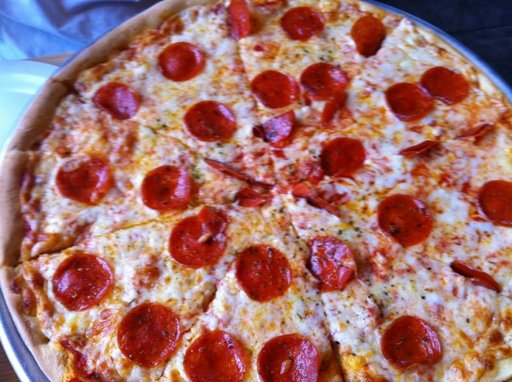

In [6]:
import random
from PIL import Image


image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick a random image
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### also possible to use mpl to do image visualization

Text(0.5, 1.0, 'steak | (512, 512, 3)')

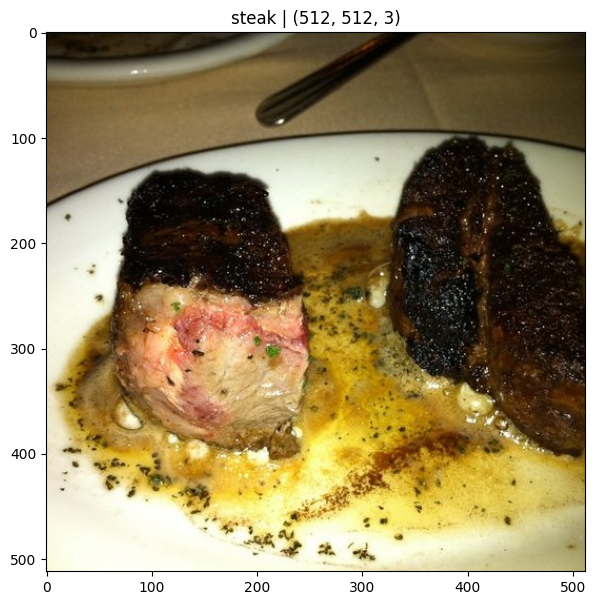

In [7]:
import matplotlib.pyplot as plt
import numpy as np
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img_arr = np.asarray(Image.open(random_image_path))
plt.figure(figsize=(10,7))
plt.imshow(img_arr)
plt.title(f"{image_class} | {img_arr.shape}") # shape -> (height, width, color_chn)

## Turn images into pytorch tensors

The images will need to be represented as an array. mpl, PIL put the color channels at the last, whereas pytorch has color channel as the first element of the array.

*Also, a torch tensor is scaled to float values 0-1 instead of 0-255 int values!*

Therefore it's necessary to preprocess the image data

Quantitatively,
1. Turn your target data into tensors (numerical representation of images)
2. Turn it into a `torch.utils.data.Dataset` dataset and subsequently a `torch.utils.data.DataLoader` dataloader for use

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Transforming data with `torchvision.transforms`

In [9]:
## write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # data augmentation to increase data diversity
    transforms.RandomHorizontalFlip(p=0.5),
    # turn image into torch tensor
    transforms.ToTensor()
])

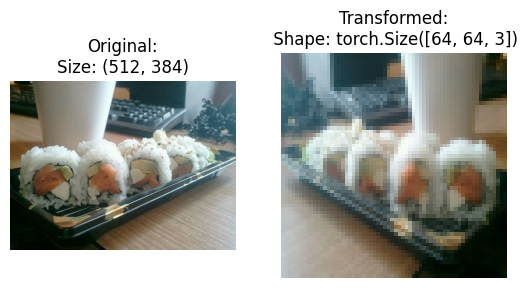

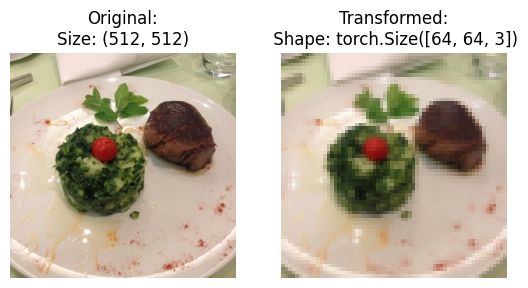

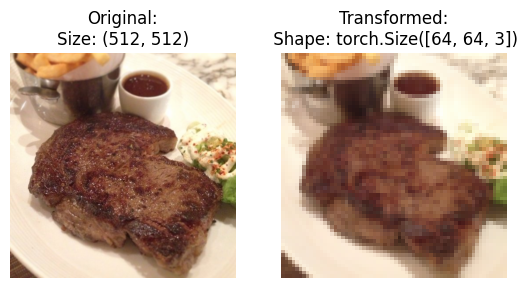

In [10]:
def plot_transformed(image_paths, transform, n=3, seed=42):
    """Select random image, transforms, then plot it"""
    # if seed:
    #     random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original:\nSize: {f.size}")
            ax[0].axis(False)

            trf_img = transform(f).permute(1,2,0) # shape (c,h,w) to (h,w,c)
            ax[1].imshow(trf_img)
            ax[1].set_title(f"Transformed:\n Shape: {trf_img.shape}")
            ax[1].axis(False)

            plt.show(fig)
plot_transformed(image_path_list, data_transform)

## Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [11]:
# Use ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(
    root=train_dir, # root directory of the trg data
    transform=data_transform, # a trf for the data
    target_transform=None # a trf for the target/label
)
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform, # a trf for the data
    target_transform=None # a trf for the target/label
)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Using prebuilt image loaders give us access to convenient attributes

# Get clss names as a list
class_names = train_data.classes
class_dict = train_data.class_to_idx


# can also index the sample (which includes the label) or just the label/target attributes
train_data.samples[0], train_data.targets[0]

(('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0), 0)

In [13]:
# Index on the train_data dataset
img,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:\n{img.shape}")
print(f"Image dtype:\n{img.dtype}")
print(f"Image label:\n{label}")
print(f"Label dtype:\n{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

original shape=torch.Size([3, 64, 64])
permuted shape=torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

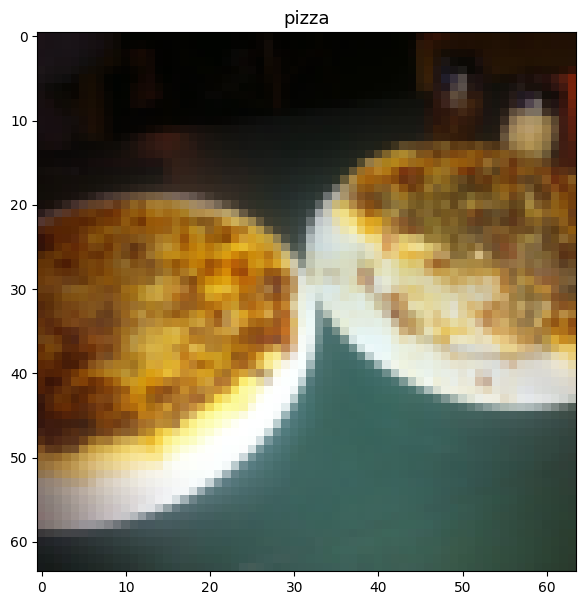

In [14]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0) # rearrange the color channels back such that the color channel (idx 0) is now last

print(f"original shape={img.shape}")
print(f"permuted shape={img_permute.shape}")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(class_names[label],fontsize=13)

## Turn the loaded images into iterable `DataLoader`

In [15]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dl = DataLoader(dataset=train_data,
                      batch_size=BATCH_SIZE,
                      num_workers=1,# can use os.cpu_count
                      shuffle=True)
test_dl = DataLoader(dataset=test_data,
                      batch_size=BATCH_SIZE,
                      num_workers=1,
                      shuffle=False)
len(train_dl),len(test_dl)

(8, 3)

In [16]:
img,label = next(iter(train_dl))
print(f"Image shape {img.shape} > (batchSize, color, h, w)")
print(f"Label shape {label.shape}")

Image shape torch.Size([32, 3, 64, 64]) > (batchSize, color, h, w)
Label shape torch.Size([32])


> Note: for the above `img`, `label`, it refers to the batch object. That is, if batch size =/= 1, it refers to the batch of images and labels, NOT the individual images and labels themselves.

# Option 2: Creating your own custom dataset class in PyTorch

Instead of using ImageFolder, let's write our own custom dataloader

Required functions
1) get class names as a list
2) get class names as a dict
3) of course, to load the images

### Pros and Cons

Pros

* Create a dataset out of almost anything
* Not limited to PyTorch prebuilt dataset functions

Cons
* The dataset might not work
* Code bloat and could be prone to errors and performance issues if code is badly written

In [17]:
import os, pathlib, torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2 as transforms
from typing import Tuple, Dict, List

In [18]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx
# (Let's model our custom dataset to output these attributes)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

1. Get class names using `os.scandir()` for a directory that follows the standard image classification format
2. Raise error if not
3. Return dict. Note: this is NOT `dict(enumerate(class_names))` !


In [19]:
target_dir = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])

In [20]:
def find_classes(dir: str) -> Tuple[List[str], Dict[str,int]]:
    classes = sorted(x.name for x in os.scandir(dir) if x.is_dir())
    if not classes:
        raise FileNotFoundError(f"No classes in {dir} found")
    class_to_idx = {name:i for i,name in enumerate(classes)}
    # it can't be dict(enumerate(classes)) as that creates a name:i dict
    return classes, class_to_idx

find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom dataset to replace `ImageFolder`

Requirements
1) Subclass `torch.utils.data.Dataset`
2) Init our subclass with a target dir
3) Create several attrs:
    - paths - paths of images
    - transform - transform we'd like to have
    - classes
    - class to idx
4) Overwrite `__getitem__()` and `__len__()`

In [21]:
from torch.utils.data import Dataset

class CustomFolder(Dataset):
    def __init__(self, target_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
    
    def load_image(self, idx: int) -> Image.Image:
        """Opens an image via a path and returns it"""
        image_path = self.paths[idx]
        return Image.open(image_path)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data as tuple (X,y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx # return (X,y)
        else:
            return img, class_idx

In [22]:
## Create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

# test out ImageFolderCustom
train_data_custom = CustomFolder(
    target_dir=target_dir,
    transform=train_transform
)

test_data_custom = CustomFolder(
    target_dir=target_dir,
    transform=test_transform
)

/Users/john/.pyenv/versions/3.11.7/envs/ml/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [23]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [24]:
# Check if our function works as expected
train_data_custom.classes==train_data.classes and \
    train_data_custom.class_to_idx==train_data.class_to_idx

True

## Create a function to display random images

1. Take in a `Dataset` to visualize
2. Cap the number of images to display at 10.
3. Set random seed
4. Get a list of random sample indices from the target dataset
5. Set up `matplotlib` plot, making sure the dimensions line up with mpl.

In [25]:
def display_images(
        dataset: torch.utils.data.Dataset,
        classes: List[str],
        n:int = 10,
        display_shape: bool = True,
        seed:int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"for display purposes, n>=10")
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)),k=n)

    plt.figure(figsize=(16,8))

    # Iterate through indices and plot them with matplotlib
    for i, sample_idx in enumerate(random_samples_idx):
        img, label = dataset[sample_idx][0], dataset[sample_idx][1]
        img_adjust = img.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(img_adjust)
        plt.axis("off")
        if classes and display_shape:
            plt.title(f"{classes[label]} {img_adjust.shape}")
        else:
            plt.title(f"{classes[label]}")

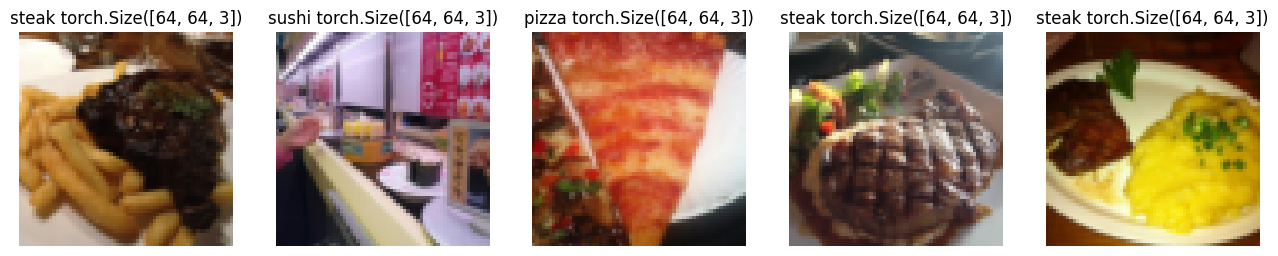

In [26]:
display_images(
    dataset=train_data,
    n=5,
    classes=class_names,
)  # with the ImageFolder

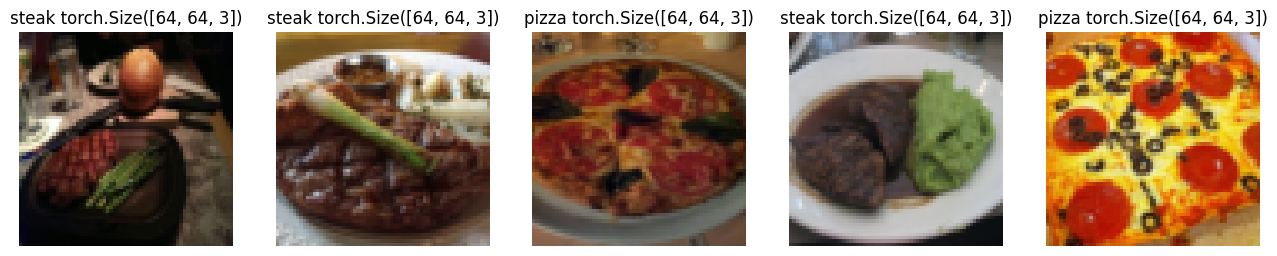

In [27]:
display_images(train_data_custom,train_data_custom.classes,5)

## Turn custom loaded images into DataLoaders

In [28]:
from torch.utils.data import DataLoader

train_dl_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)
test_dl_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)
train_dl_custom, test_dl_custom

(<torch.utils.data.dataloader.DataLoader at 0x1666dab10>,
 <torch.utils.data.dataloader.DataLoader at 0x16662f090>)

In [29]:
# Get image and label from dl
X,y = next(iter(train_dl_custom))
X.shape, y.shape

# you can use this as any other dataloader now

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [30]:
## Other forms of data augmentation/transforms

from torchvision import transforms

train_transform = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # a random intensity on scale of from 0 - 31 is chosen
    transforms.ToTensor()]
)

test_transform = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.ToTensor()]
) # test transform will not have augmentation

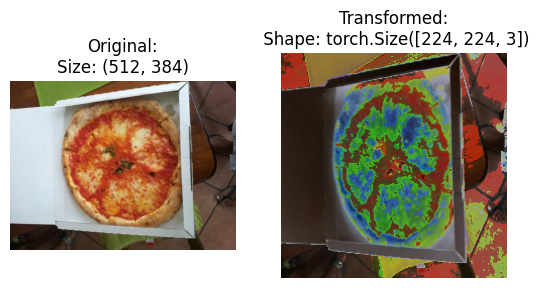

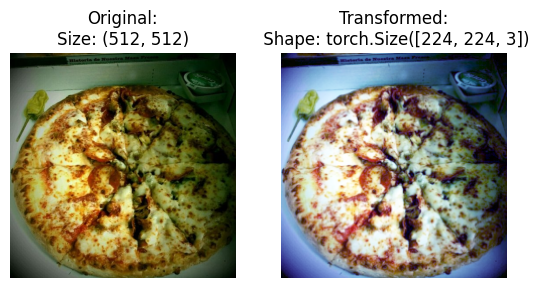

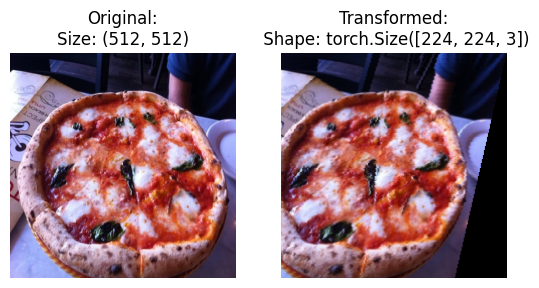

In [31]:
# Plot random dataloaded images
plot_transformed(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## Model 0: Baseline model (TinyVGG) without any augmentation
Replicate the architecture from the CNN reference website.

## For practice, load transforms and data for model

In [32]:
# create simple transform to make images into desired input size
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
]
)

In [33]:
from torchvision import datasets
# load and transform data into a dataset
train_data_sample = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)
test_data_sample = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# turn datasets into dataloaders
from torch.utils.data import DataLoader
NUM_WORKERS = 0 # os.cpu_count() is much slower for smaller datasets.
train_dataloader = DataLoader(
    dataset=train_data_sample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
test_dataloader = DataLoader(
    dataset=test_data_sample,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

## Create the TinyVGG Model Class

In [34]:
from torch import nn
import torch

class TinyVGG(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_shape,
                kernel_size=3,
                out_channels=hidden_units,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                kernel_size=3,
                out_channels=hidden_units,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2 # for MaxPool2d, default stride=ksize
            )
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                kernel_size=3,
                out_channels=hidden_units,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                kernel_size=3,
                out_channels=hidden_units,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2 # for MaxPool2d, default stride=ksize
            )
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # vectorize the result
            nn.Linear(
                in_features=hidden_units*13*13,
                out_features=out_shape
            )
        )
    
    """Note: The forward pass is first deliberately written
    without operator fusion so as to determine the shape of
    the flatten layer."""

    def forward(self,x):
        # print(x.shape)
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [35]:
DEVICE

'mps'

In [36]:
torch.manual_seed(42)
# instantiate a model
model_0 = TinyVGG(
    in_shape=3, # number of color channels
    hidden_units=10,
    out_shape=len(class_names)
).to(DEVICE)

In [399]:
# forward pass dummy data into the model by passing a single image
images, labels = map(lambda x: x.to(DEVICE), next(iter(train_dataloader)))

In [400]:
model_0(images)

tensor([[ 0.0196, -0.0014,  0.0108],
        [ 0.0209,  0.0001,  0.0089],
        [ 0.0198, -0.0038,  0.0090],
        [ 0.0191, -0.0013,  0.0104],
        [ 0.0228, -0.0037,  0.0093],
        [ 0.0245, -0.0048,  0.0085],
        [ 0.0209,  0.0001,  0.0084],
        [ 0.0224, -0.0014,  0.0080],
        [ 0.0179,  0.0004,  0.0087],
        [ 0.0186, -0.0042,  0.0095],
        [ 0.0182, -0.0003,  0.0076],
        [ 0.0183, -0.0008,  0.0152],
        [ 0.0183,  0.0002,  0.0060],
        [ 0.0213, -0.0039,  0.0110],
        [ 0.0232, -0.0035,  0.0095],
        [ 0.0198, -0.0023,  0.0090],
        [ 0.0202, -0.0023,  0.0073],
        [ 0.0211, -0.0018,  0.0083],
        [ 0.0203,  0.0033,  0.0065],
        [ 0.0219, -0.0002,  0.0091],
        [ 0.0186, -0.0020,  0.0091],
        [ 0.0205, -0.0025,  0.0085],
        [ 0.0208,  0.0018,  0.0080],
        [ 0.0194,  0.0016,  0.0103],
        [ 0.0216, -0.0044,  0.0095],
        [ 0.0195, -0.0022,  0.0100],
        [ 0.0197, -0.0009,  0.0093],
 

## Use `torchinfo` to get information from the model
Instead of using print statements inside the model like above, there is a better way of getting relevant info for what is happening inside the model.

In [383]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])
# torchinfo calls the forward method on model_0 to provide shape change info as data moves through the model

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# Training and testing the model
Use `train_step` and `test_step` functions that takes in a dataloader, model, loss, etc etc.

In [384]:
DEVICE='mps'

In [37]:
def train_step(model:nn.Module, dl:torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optim: torch.optim.Optimizer):
    # Set into training mode
    model.train()

    # Set up train loss and accuracy values to accumulate through the batch
    train_loss, train_acc = 0,0
    
    # Loop through the batched data in the dataloader
    for X_batch, y_batch in dl:
        X,y = X_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
        y_pred_class = y_pred.argmax(dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    train_loss /= len(dl)
    train_acc /= len(dl)
    return train_loss,train_acc

In [38]:
def test_step(model:nn.Module, dl:torch.utils.data.DataLoader, loss_fn:nn.Module):
    model.eval()
    test_loss,test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = model(X)
            # pred_probs = torch.softmax(y_pred) if you ever need the probabilities
            test_loss += loss_fn(y_pred,y).item()
            test_pred_labels = y_pred.argmax(dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)
    
    test_loss /= len(dl)
    test_acc /= len(dl)
    return test_loss, test_acc

## Creating a `train()` function to combine `train_step()` and `test_step()`

In [39]:
from tqdm.auto import tqdm

def train(model:nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optim:torch.optim.Optimizer,
          loss:nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          ):
    res = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_step(model, train_dataloader,loss,optim)
        test_loss,test_acc = test_step(model, test_dataloader,loss)

        print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.3f}")
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")
        
        # Update results dictionary
        res["train_loss"].append(train_loss)
        res["train_acc"].append(train_acc)
        res["test_loss"].append(test_loss)
        res["test_acc"].append(test_acc)

    return res

In [40]:
# Train and eval model 0

torch.manual_seed(42)
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.001)

model_0_results = train(model_0,
      train_dataloader,
      test_dataloader,
      optimizer,
      epochs=NUM_EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train loss: 1.1035 | Train acc: 0.250
Test loss: 1.0993 | Test acc: 0.260
Epoch 1 | Train loss: 1.0761 | Train acc: 0.426
Test loss: 1.1300 | Test acc: 0.260
Epoch 2 | Train loss: 1.0727 | Train acc: 0.426
Test loss: 1.1627 | Test acc: 0.260
Epoch 3 | Train loss: 1.1125 | Train acc: 0.305
Test loss: 1.1531 | Test acc: 0.260
Epoch 4 | Train loss: 1.0839 | Train acc: 0.363
Test loss: 1.1511 | Test acc: 0.240
Epoch 5 | Train loss: 1.0841 | Train acc: 0.418
Test loss: 1.1290 | Test acc: 0.312
Epoch 6 | Train loss: 0.9971 | Train acc: 0.570
Test loss: 1.1200 | Test acc: 0.281
Epoch 7 | Train loss: 0.9975 | Train acc: 0.539
Test loss: 1.0652 | Test acc: 0.312
Epoch 8 | Train loss: 0.9852 | Train acc: 0.465
Test loss: 1.0221 | Test acc: 0.341
Epoch 9 | Train loss: 0.8742 | Train acc: 0.504
Test loss: 0.9404 | Test acc: 0.545


Okay, so this baseline model sucks. There are quite a few thing to do to improve model performance (dataset augmentation, more conv blocks, different type of activation functions etc)

## Let's plot the loss curves
Loss curves of a model tracks its performance over time.

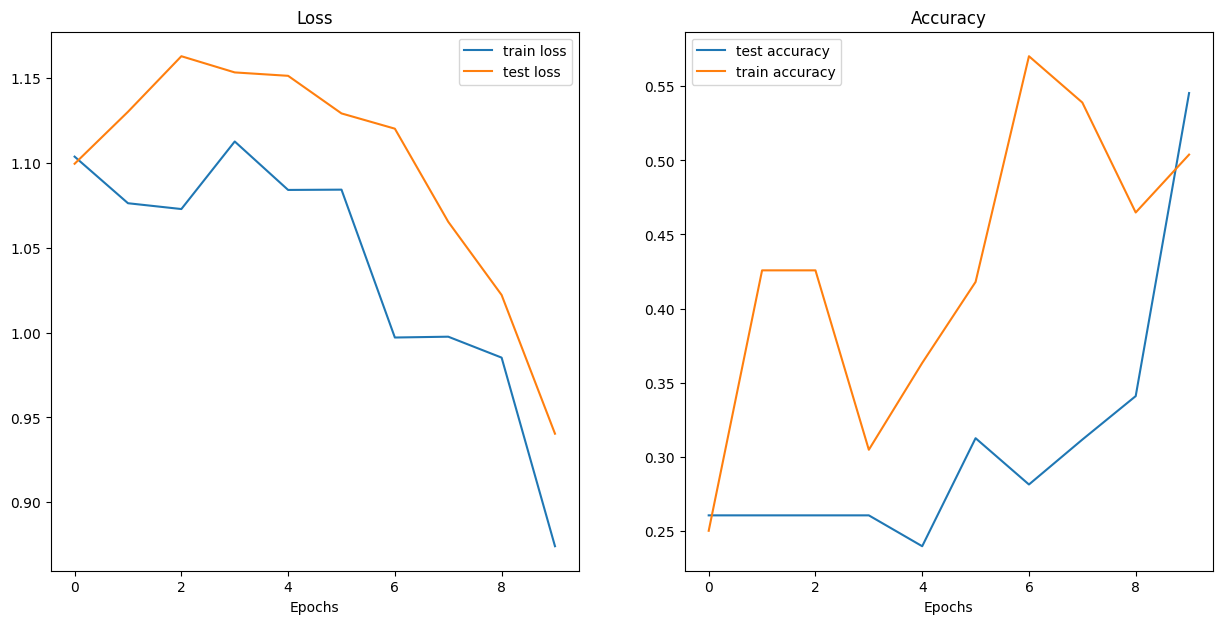

In [41]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get loss values of res dictionary
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"])) # make it iterable

    # set up plot 
    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, test_loss, label='test loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, test_accuracy, label="test accuracy")
    plt.plot(epochs, accuracy, label="train accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
plot_loss_curves(model_0_results)

## Model 1: TinyVGG with data augmentation

In [43]:
# create training trf with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

# Create dataset and dataloader
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,transform=test_transform_simple)

torch.manual_seed(42)

train_dl_aug = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)
test_dl_aug = DataLoader(
    dataset=test_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [52]:
# Construct and train model 1
torch.manual_seed(42)

model_1 = TinyVGG(3,10,10).to(DEVICE)

optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

model_1_results = train(
    model_1, train_dl_aug, test_dl_aug, optimizer, epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train loss: 1.9482 | Train acc: 0.367
Test loss: 1.4580 | Test acc: 0.542
Epoch 1 | Train loss: 1.2446 | Train acc: 0.270
Test loss: 1.0922 | Test acc: 0.260
Epoch 2 | Train loss: 1.0927 | Train acc: 0.426
Test loss: 1.1848 | Test acc: 0.260
Epoch 3 | Train loss: 1.1419 | Train acc: 0.309
Test loss: 1.0849 | Test acc: 0.382
Epoch 4 | Train loss: 1.1994 | Train acc: 0.305
Test loss: 1.0818 | Test acc: 0.350
Epoch 5 | Train loss: 1.0437 | Train acc: 0.469
Test loss: 1.2126 | Test acc: 0.260
Epoch 6 | Train loss: 1.1690 | Train acc: 0.305
Test loss: 1.1464 | Test acc: 0.260
Epoch 7 | Train loss: 1.0970 | Train acc: 0.316
Test loss: 1.1176 | Test acc: 0.250
Epoch 8 | Train loss: 1.0756 | Train acc: 0.480
Test loss: 1.1466 | Test acc: 0.302
Epoch 9 | Train loss: 1.1336 | Train acc: 0.348
Test loss: 1.1201 | Test acc: 0.260


# Plot loss curves of model 1

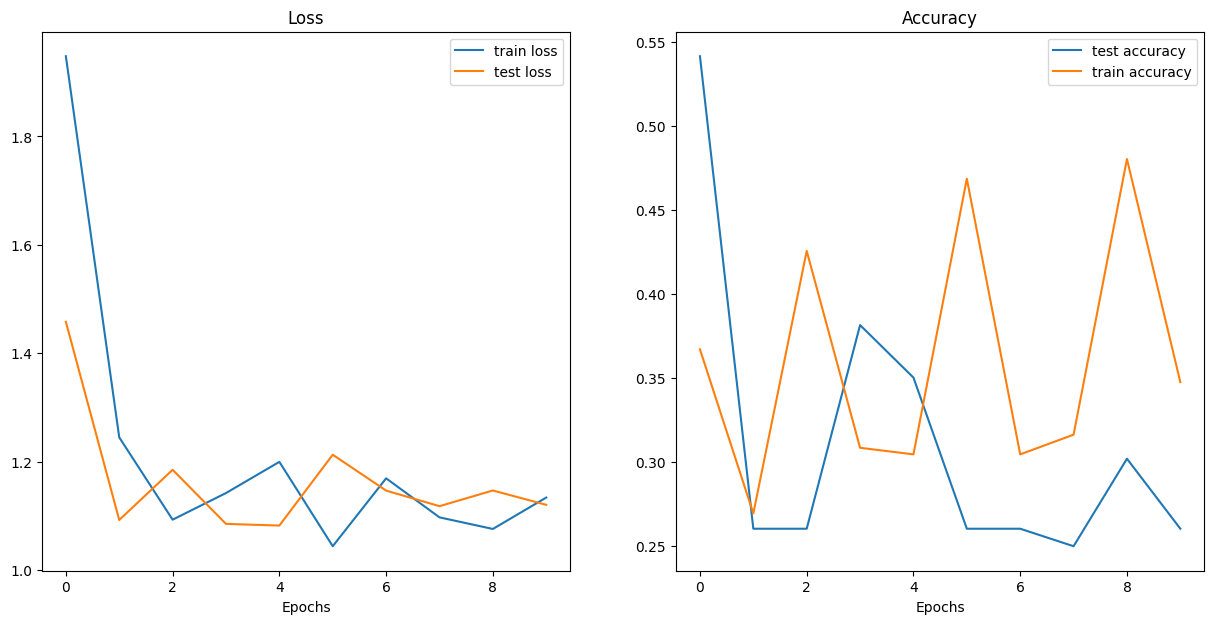

In [53]:
plot_loss_curves(model_1_results)

### Comparing models with each other

There's a few different way to do this.

* pure code
* pytorch + tensorboard
* weights and biases (wandb.ai)
* MLflow (mlflow.org)

In [54]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

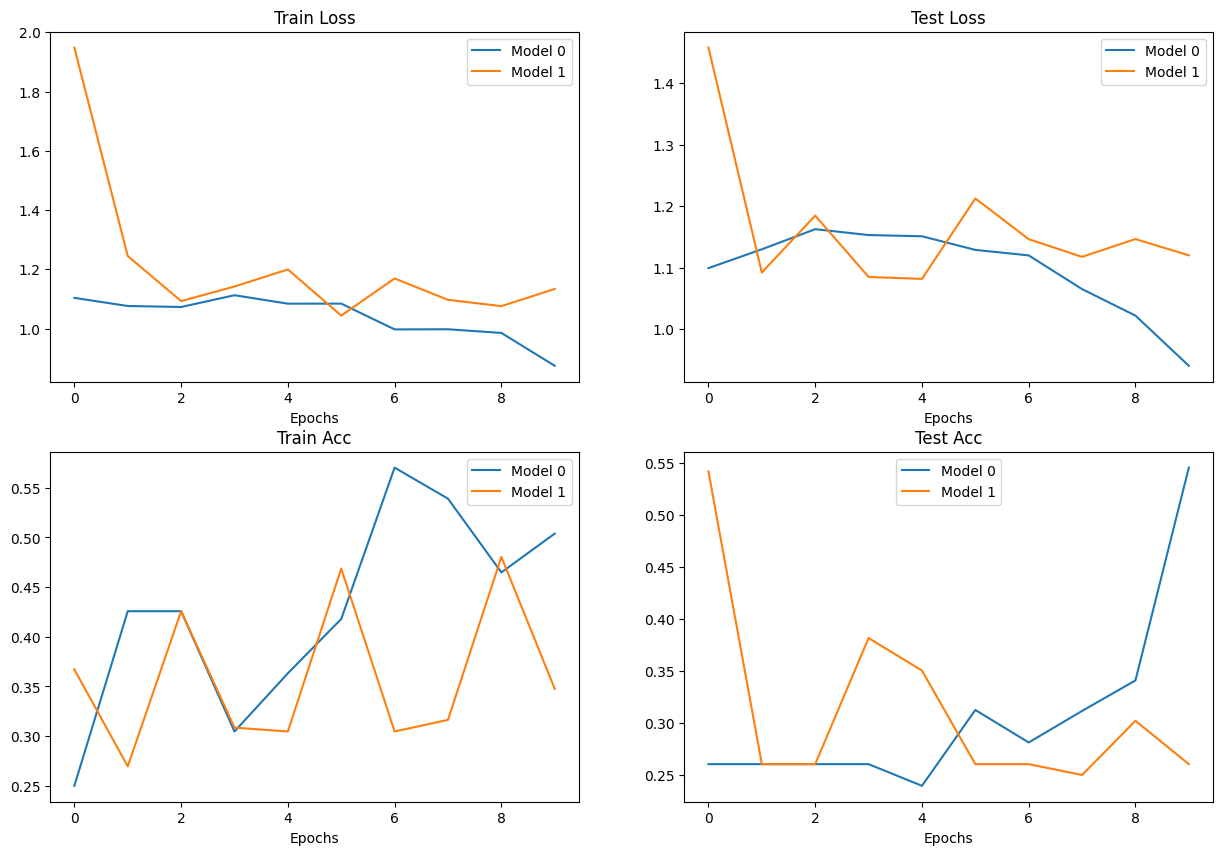

In [55]:
# set up a plot and get epochs
plt.figure(figsize=(15,10))
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()


# Making a prediction on a custom image that isn't in the data
What if the image is not in either train or test?

In [56]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)

### Loading in that image
We have to make sure that the image is in the same shape (res) on the same target device.

In [75]:
import torchvision

# read in custom inage
custom_img = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

In [89]:
model_1.eval()
from torchvision.transforms import functional as T

# NOTE: the image NEEDS to be unsqueezed to account for batch size.

# _trf = transforms.Compose([transforms.Resize(size=(64,64))])
# custom_img_trf = _trf(custom_img).unsqueeze(0) #

# custom_img_trf.shape
# with torch.inference_mode():
#     model_1(custom_img_trf.to(DEVICE))

with torch.inference_mode():
    custom_preds = model_1(T.resize(custom_img, size=(64,64),antialias=True).unsqueeze(0).to(DEVICE))

# Convert logits to probs
labels = custom_preds.argmax()
class_names[labels]



'pizza'

### Final notes on custom data

When predicting on custom data, need to make sure
1) The data is in the right datatype - for example the image is saved in bytes (uint8) but needs to be converted to `torch.float32`
2) Data needs to be loaded on the same device, and crucially,
3) The SHAPE of the data needs to be correct!! Either you add a batch dimension by unsqueezing or permuting the arrangements of the color channels